In [1]:
import pandas as pd
import torch
from torch import nn
from preprocess import load_argumentation
from resnet18 import resnet18
from d2l import torch as d2l

loss = nn.CrossEntropyLoss(reduction="none")
train_iter, train_valid_iter, valid_iter, test_iter, train_valid_ds, test_ds = load_argumentation()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

训练样本为前45000个。


In [2]:
def train_network(net, X, y, loss, optimizer, device):
    if isinstance(X, list):
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)
    y = y.to(device)
    net.train()
    optimizer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    optimizer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, valid_iter, num_epochs, lr, wd, device, lr_period,
          lr_decay):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_network(net, features, labels,
                                          loss, optimizer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(device)}')

train loss 0.228, train acc 0.921, valid acc 0.798
2355.1 examples/sec on cuda:0


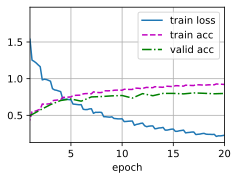

In [3]:

num_epochs, lr, wd = 20, 5e-5, 5e-2
lr_period, lr_decay, net = 4, 0.9, resnet18(10, 3).to(device)
train(net, train_iter, valid_iter, num_epochs, lr, wd, device, lr_period,
      lr_decay)

train loss 0.220, train acc 0.925
2394.9 examples/sec on cuda:0


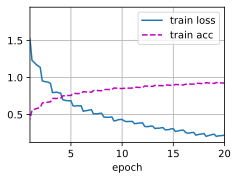

In [4]:
net, preds = resnet18(10, 3).to(device), []
train(net, train_valid_iter, None, num_epochs, lr, wd, device, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(device))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)